# Make composite figures

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import datacube

In [2]:
import numpy as np
from scipy import ndimage

In [3]:
import seaborn as sns
from astropy.stats import histogram

In [4]:
import xarray as xr

In [5]:
import glob

In [6]:
plt.gcf().canvas.get_supported_filetypes()

{'ps': 'Postscript',
 'eps': 'Encapsulated Postscript',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format'}

<Figure size 432x288 with 0 Axes>

In [7]:
dc = datacube.Datacube()

In [253]:

def all_data(area):
    clean_1 = xr.open_dataset('apsar_s1_water_train_s1_%s.nc'%area)
    wofs = xr.open_dataset('apsar_s1_water_train_wofs_%s.nc'%area)
    # date with most water
    example_index = (wofs.water==1).groupby('time').mean().argmax()
    ls8_time =wofs.time.values[example_index]
    print(ls8_time)
    ls8 = dc.load(product='ls8_nbart_albers',
                  x=(wofs.x[0].values,wofs.x[-1].values),
                  y=(wofs.y[0].values,wofs.y[-1].values), crs='EPSG:3577',
                  time=(str(ls8_time)[:10],str(ls8_time+np.timedelta64(1,'D'))[:10]),
                  measurements=['red','green','blue'],
                  group_by='solar_day')
    # wofs summary
    wofs_summary_files = glob.glob('/g/data/u46/users/fxy120/wofs_stats_2016_2018/WOFS_3577_*_2016_2018_summary.nc')
    wofs_summary_1 = None
    for f in wofs_summary_files:
        wofs_summary = xr.open_dataset(f)
        try:
            wofs_summary_1 = wofs_summary.isel(time=0).sel(x=wofs.x.values, y = wofs.y.values)
            break
        except:
            continue
    if wofs_summary_1 is None:
        wofs_summary_files = glob.glob('/g/data/u46/users/fxy120/wofs_stats_2016_2018/WOFS_3577_*_-41_2016_2018_summary.nc')
        wofs_summary = xr.open_mfdataset(wofs_summary_files)
        wofs_summary_1 = wofs_summary.isel(time=0).sel(x=wofs.x.values, y = wofs.y.values)
    return clean_1, wofs, ls8, wofs_summary_1,example_index

clean_1, wofs_1, ls8_1, wofs_summary_1, ind_1 = all_data('menindee')
clean_2, wofs_2, ls8_2, wofs_summary_2, ind_2 = all_data('eucumbene')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


2016-12-10T00:20:41.000000000


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


2016-01-12T23:56:57.000000000


In [254]:
min_vv, max_vv = min(clean_1.vv.min(), clean_2.vv.min()), max(clean_1.vv.max(), clean_2.vv.max())
min_vh, max_vh = min(clean_1.vh.min(), clean_2.vh.min()), max(clean_1.vh.max(), clean_2.vh.max())

In [255]:
min_vv, max_vv, min_vh, max_vh

(<xarray.DataArray 'vv' ()>
 array(1.866525e-07), <xarray.DataArray 'vv' ()>
 array(0.790577), <xarray.DataArray 'vh' ()>
 array(2.366491e-06), <xarray.DataArray 'vh' ()>
 array(0.136519))

In [256]:
vv=np.append(clean_1.vv.values.ravel(), clean_2.vv.values.ravel())
vh=np.append(clean_1.vh.values.ravel(), clean_2.vh.values.ravel())
water_mask = np.append(wofs_1.water.values.ravel(), wofs_2.water.values.ravel())

In [243]:
#clean_1, wofs_1, ls8_1, wofs_summary_1, ind_1 = all_data('eucumbene')
#vv=clean_1.vv.values.ravel()
#vh=clean_1.vh.values.ravel()
#water_mask = wofs_1.water.values.ravel()

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


2016-01-12T23:56:57.000000000


In [257]:
vv=vv[water_mask<2]
vh=vh[water_mask<2]
water_mask=water_mask[water_mask<2]

In [266]:
xedges, yedges = np.arange(0,0.1,0.001),np.arange(0,0.1,0.001)
hist, xe, ye=np.histogram2d(vv,vh,bins=[xedges, yedges])

In [267]:
hist_water, xe, ye=np.histogram2d(vv[water_mask==1],vh[water_mask==1],bins=[xedges, yedges])

In [268]:
hist_water_norm = hist_water/hist_water.sum()
hist_norm = hist/hist.sum()

In [269]:
hist_b = hist_water_norm*hist_water.sum()/hist_norm/hist.sum()

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [270]:
np.nanmax(hist_b)

1.0000000000000002

In [271]:
#hist_b[(hist_norm==0) & (hist_water_norm>0)]=1

In [272]:
#hist_b[np.isnan(hist_b)]=0

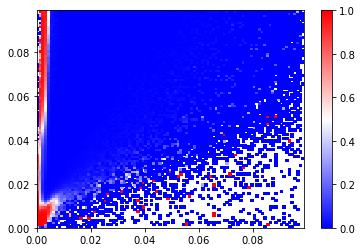

In [273]:
from matplotlib.colors import LogNorm
X, Y = np.meshgrid(yedges, xedges)
plt.pcolor(X,Y,hist_b, cmap='bwr')#, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()

In [9]:
def hist_water_nonwater(ds, band, water_ds, ax, binmax=0.1):
    
    if binmax is None:binmax = np.nanpercentile(ds[band], 90)
    ds[band].where(water_ds.water.values==1).plot(label='water', bins=np.arange(0,binmax,0.0002), alpha=0.8, color='b',ax = ax);
    ds[band].where(water_ds.water.values==0).plot(label='not water', bins=np.arange(0,binmax,0.0002), alpha=0.7, color='orange',ax = ax);
    #ds[band].where(water_ds.water.values==2).plot(label='uncertain', bins=np.arange(0,binmax,0.0002), ax = ax);
    ax.set_xlim((0,binmax))
    ax.legend()


In [10]:
def hist_water_nonwater_db(ds, band, water_ds, ax, bins=np.arange(-30,-10,0.01)):
    
    water = (np.log10(ds[band].where(water_ds.water.values==1))*10)
    water.plot(label='water', bins=bins, alpha=0.7, color='blue',ax = ax, density=True);
    nonwater =  (np.log10(ds[band].where(water_ds.water.values==0))*10)
    nonwater.plot(label='not water', bins=bins, alpha=0.7, color='orange',ax = ax, density=True);
    #ds[band].where(water_ds.water.values==2).plot(label='uncertain', bins=np.arange(0,binmax,0.0002), ax = ax);
    ax.set_xlim((bins[0],np.ceil(bins[-1])))
    ax.legend(frameon=False)

#f, ax = plt.subplots(1,2)
#hist_water_nonwater_db(clean_1, 'vv', wofs_1, ax[0])
#hist_water_nonwater_db(clean_1, 'vh', wofs_1, ax[1])


In [11]:
def sar_rgb(clean_2, ind_2, ax):
    clean_2_example = clean_2.isel(time=ind_2).copy()
    #clean_2_example['vh']=np.log10(clean_2_example.vh)*10.
    #clean_2_example['vv']=np.log10(clean_2_example.vv)*10.
    clean_2_example['vh/vv']=clean_2_example.vh/clean_2_example.vv
    med = clean_2_example[['vh','vv','vh/vv']].median()
    return (clean_2_example[['vh','vv','vh/vv']]/med).to_array().plot.imshow(robust=True, ax=ax)

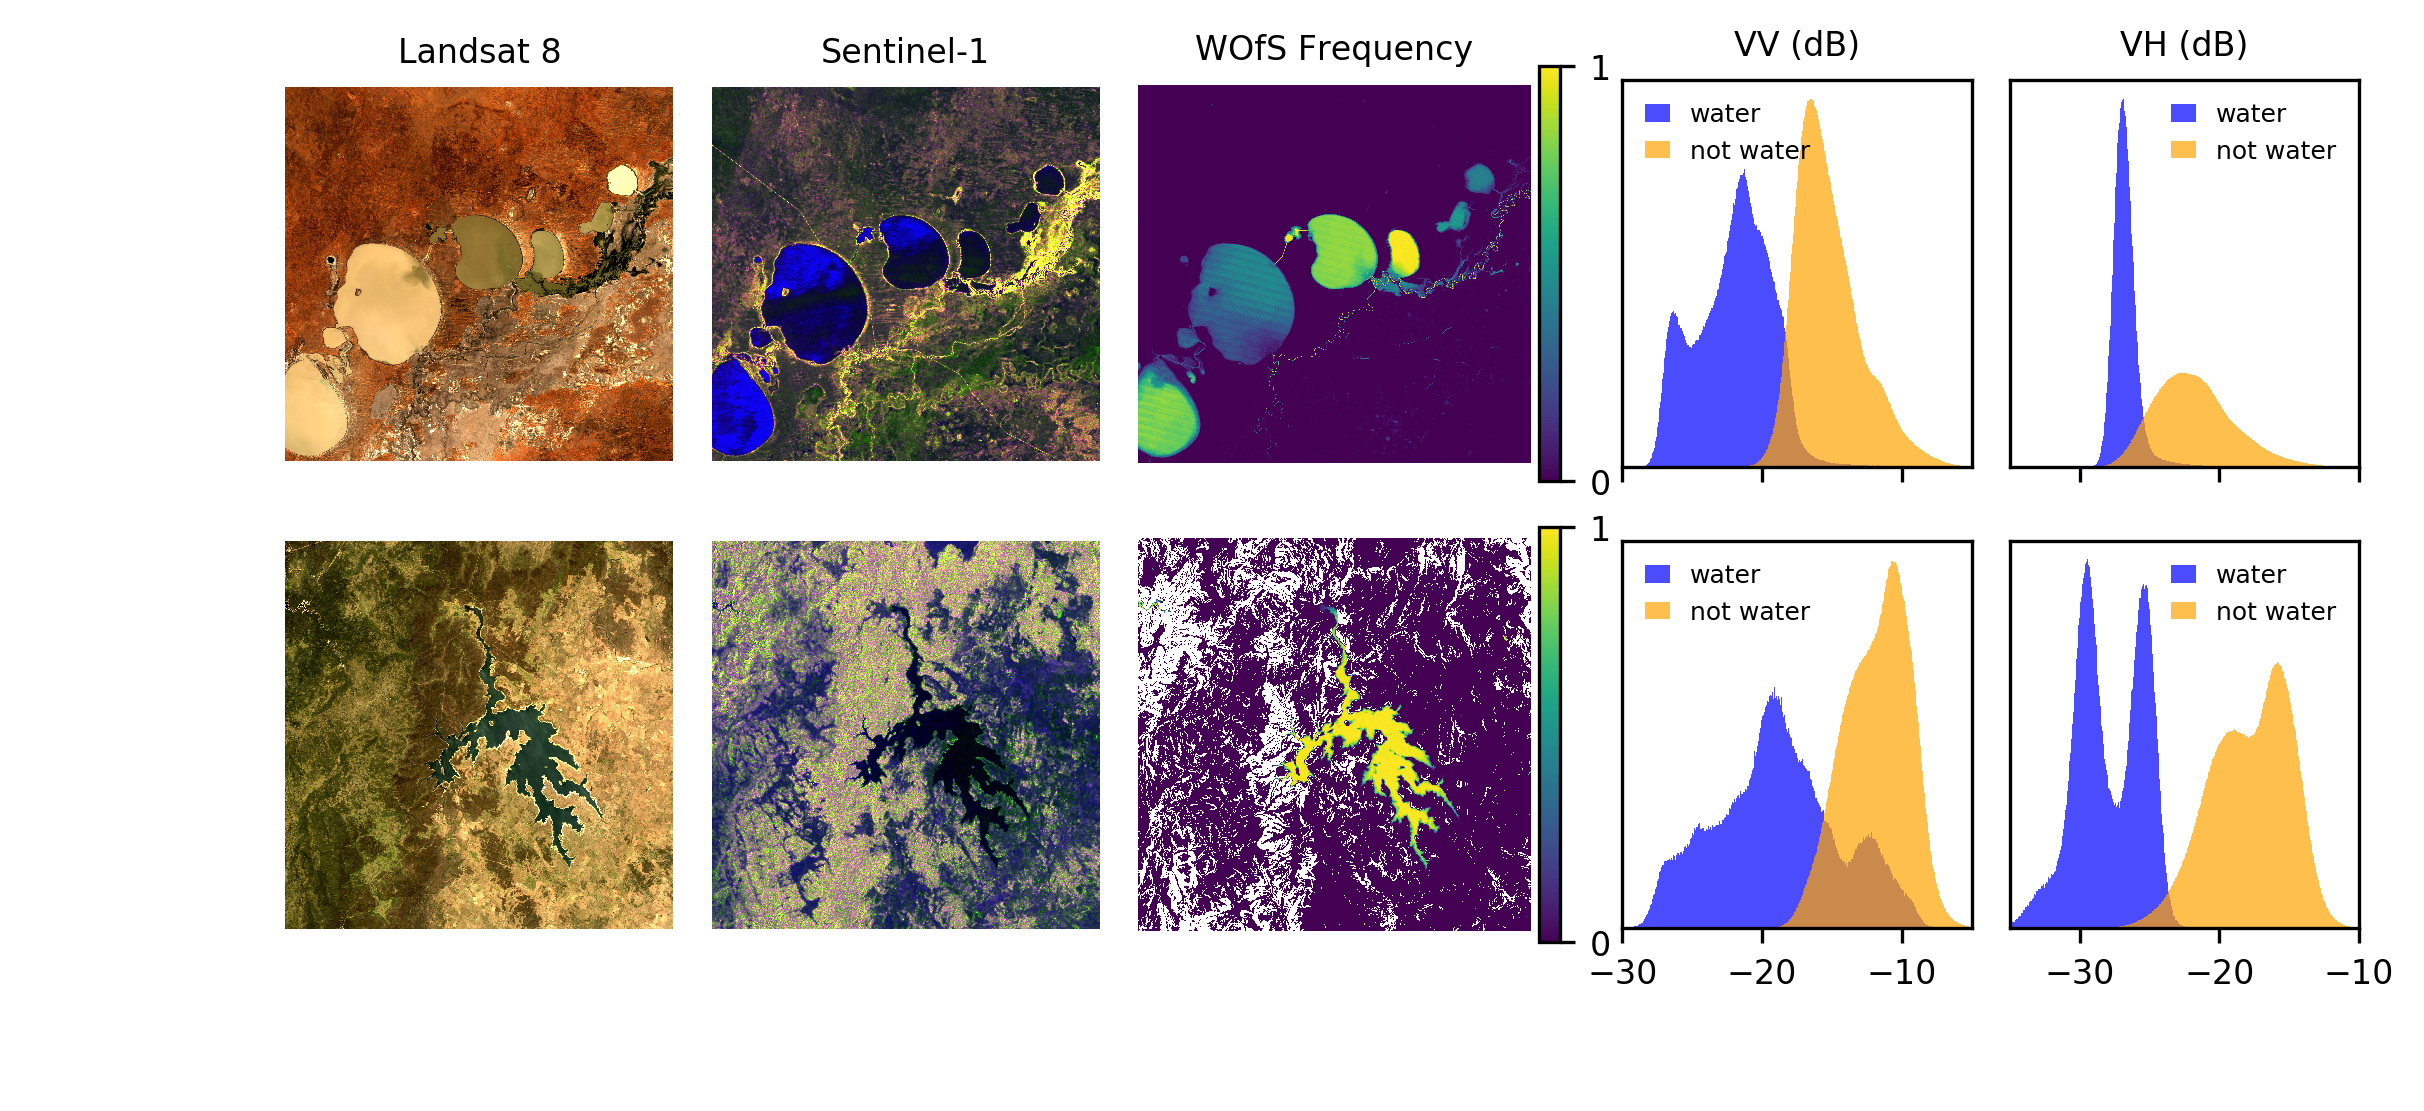

In [12]:
plt.rcParams.update({'axes.labelsize': 8, 'axes.titlesize':8, 'font.size':8,
                     'legend.fontsize':6,'legend.handlelength':1})

f, ax= plt.subplots(2, 5, figsize=(7.2,3.2), dpi=300, 
                    gridspec_kw={'left':0.02, 'right':0.98, 'top':0.98, 'bottom':0.02,
                                 'wspace':0.1, 'hspace':0.0, 'width_ratios':[1.,1.,1.15,0.9,0.9]})

# ls8 true color
ls8_1.isel(time=0).to_array().plot.imshow(robust=True,ax=ax[0,0])
ax[0,0].set_title('Landsat 8')
ax[0,0].set_axis_off()
ax[0,0].set_aspect('equal')
ax[0,0].margins(0.0)

# wofs water frequency
wofs_summary_1.frequency.rename('').plot.imshow(ax=ax[0,2],
                                              cbar_kwargs={'label':'','ticks':[0,1],'fraction':0.1,'shrink':0.9,
                                                           'pad':0.02,'format':'%.0f'})
ax[0,2].set_title('WOfS Frequency')
ax[0,2].axis('off')
ax[0,2].set_aspect('equal')
ax[0,2].margins(0.0)

# SAR
sar_rgb(clean_1, ind_1, ax[0,1])
ax[0,1].set_title('Sentinel-1')
ax[0,1].set_axis_off()
ax[0,1].set_aspect('equal')
ax[0,1].margins(0.0)

# VV distribution
hist_water_nonwater_db(clean_1, 'vv', wofs_1, ax[0,3], bins=np.arange(-30,-5,0.05))
ax[0,3].set_title('VV (dB)')
ax[0,3].set_yticks([])
ax[0,3].set_xlabel('')
ax[0,3].set_xticklabels([])
ll, bb, ww, hh = ax[0,3].get_position().bounds
ax[0,3].set_position([ll, bb+hh*0.08, ww, hh*0.84])

# VH
hist_water_nonwater_db(clean_1, 'vh', wofs_1, ax[0,4], bins=np.arange(-35,-10,0.05))
ax[0,4].set_title('VH (dB)')
ax[0,4].set_yticks([])
ax[0,4].set_xlabel('')
ax[0,4].set_xticklabels([])
ll, bb, ww, hh = ax[0,4].get_position().bounds
ax[0,4].set_position([ll, bb+hh*0.08, ww, hh*0.84])


# second row


# ls8 true color
ls8_2.isel(time=0).to_array().plot.imshow(robust=True,ax=ax[1,0])
ax[1,0].set_title('')
ax[1,0].axis('off')
ax[1,0].set_aspect('equal')
ax[1,0].margins(0.0)

# wofs water frequency
wofs_summary_2.frequency.rename('').plot.imshow(ax=ax[1,2],
                                              cbar_kwargs={'label':'','ticks':[0,1],'fraction':0.1,'shrink':0.9,
                                                           'pad':0.02,'format':'%.0f'})
ax[1,2].set_title('')
ax[1,2].axis('off')
ax[1,2].set_aspect('equal')
ax[1,2].margins(0.0)

# SAR
sar_rgb(clean_2, ind_2, ax=ax[1,1])
ax[1,1].set_title('')
ax[1,1].set_axis_off()
ax[1,1].set_aspect('equal')
ax[1,1].margins(0.0)

# VV distribution
hist_water_nonwater_db(clean_2, 'vv', wofs_2, ax[1,3], bins=np.arange(-30,-5,0.05))
ax[1,3].set_yticks([])
ax[1,3].set_title('')
ax[1,3].set_xlabel('')
ll, bb, ww, hh = ax[1,3].get_position().bounds
ax[1,3].set_position([ll, bb+hh*0.08, ww, hh*0.84])

# VH
hist_water_nonwater_db(clean_2, 'vh', wofs_2, ax[1,4], bins=np.arange(-35,-10,0.05))
ax[1,4].set_yticks([])
ax[1,4].set_title('')
ax[1,4].set_xlabel('')
ll, bb, ww, hh = ax[1,4].get_position().bounds
ax[1,4].set_position([ll, bb+hh*0.08, ww, hh*0.84])


#f.tight_layout()
#f.subplots_adjust(left=0.01,hspace=0.1,wspace=0.1)
#f.savefig('apsar_fig_train.eps', format='eps',dpi=300)
f.savefig('apsar_fig_train.png', format='png', dpi=300, bbox_inches='tight')
f.savefig('apsar_fig_train.tiff',format='tiff', dpi=300, bbox_inches='tight')


In [13]:
!ls apsar*.nc

apsar_classified_base_george.nc
apsar_classified_base_tasmania.nc
apsar_classified_fortest_base_george.nc
apsar_classified_fortest_base_tasmania.nc
apsar_classified_fortest_ind_george.nc
apsar_classified_fortest_ind_tasmania.nc
apsar_classified_fortest_rel_george.nc
apsar_classified_fortest_rel_tasmania.nc
apsar_classified_ind_george.nc
apsar_classified_ind_tasmania.nc
apsar_classified_rel_george.nc
apsar_classified_rel_tasmania.nc
apsar_s1_water_train_s1_eucumbene.nc
apsar_s1_water_train_s1_george.nc
apsar_s1_water_train_s1_menindee.nc
apsar_s1_water_train_s1_tasmania.nc
apsar_s1_water_train_wofs_eucumbene.nc
apsar_s1_water_train_wofs_george.nc
apsar_s1_water_train_wofs_menindee.nc
apsar_s1_water_train_wofs_tasmania.nc


In [14]:
wofs_1.water.values.shape, wofs_2.water.values.shape

((14, 1936, 2009), (10, 1777, 1776))